In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/global_power_plant_database.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())




  country country_long                                              name  \
0     AFG  Afghanistan      Kajaki Hydroelectric Power Plant Afghanistan   
1     AFG  Afghanistan                                      Kandahar DOG   
2     AFG  Afghanistan                                      Kandahar JOL   
3     AFG  Afghanistan     Mahipar Hydroelectric Power Plant Afghanistan   
4     AFG  Afghanistan  Naghlu Dam Hydroelectric Power Plant Afghanistan   

      gppd_idnr  capacity_mw  latitude  longitude primary_fuel other_fuel1  \
0  GEODB0040538         33.0    32.322    65.1190        Hydro         NaN   
1    WKS0070144         10.0    31.670    65.7950        Solar         NaN   
2    WKS0071196         10.0    31.623    65.7920        Solar         NaN   
3  GEODB0040541         66.0    34.556    69.4787        Hydro         NaN   
4  GEODB0040534        100.0    34.641    69.7170        Hydro         NaN   

  other_fuel2  ... estimated_generation_gwh_2013  \
0         NaN  ...    

/tmp/ipython-input-2132296752.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/global_power_plant_database.csv')


In [166]:
# ----------------------------
# DATA CLEANING
# ----------------------------

# Drop columns with too many missing values
df = df.drop(columns=["other_fuel1", "other_fuel2", "other_fuel3"])

# Keep commissioning_year as NaN for correct time-series plots (no filling with median)
if "commissioning_year" in df.columns:
    df['commissioning_year'] = pd.to_numeric(df['commissioning_year'], errors='coerce')

# Convert numeric columns explicitly
numeric_cols = ['capacity_mw', 'latitude', 'longitude'] + \
    [col for col in df.columns if 'generation_gwh' in col or 'estimated_generation_gwh' in col]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

print("✅ Data cleaning complete! Columns dropped: other_fuel1, other_fuel2, other_fuel3")
print(f"🔎 Missing years in commissioning_year: {df['commissioning_year'].isna().sum()}")



✅ Data cleaning complete! Columns dropped: other_fuel1, other_fuel2, other_fuel3
🔎 Missing years in commissioning_year: 17489



📊 Descriptive statistics for numeric columns:
        capacity_mw      latitude     longitude  generation_gwh_2013  \
count  34936.000000  34936.000000  34936.000000          6417.000000   
mean     163.355148     32.816637     -6.972803           592.696107   
std      489.636072     22.638603     78.405850          2174.833482   
min        1.000000    -77.847000   -179.977700          -947.600000   
25%        4.900000     29.256475    -77.641550             1.947000   
50%       16.745000     39.727750     -2.127100            23.426000   
75%       75.344250     46.263125     49.502675           199.706000   
max    22500.000000     71.292000    179.388700         50834.000000   

       generation_gwh_2014  generation_gwh_2015  generation_gwh_2016  \
count          7226.000000          8203.000000          9144.000000   
mean            656.863891           762.368840           693.149763   
std            2231.464288          2533.459828          2404.516759   
min            -

/tmp/ipython-input-1682933540.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="viridis")


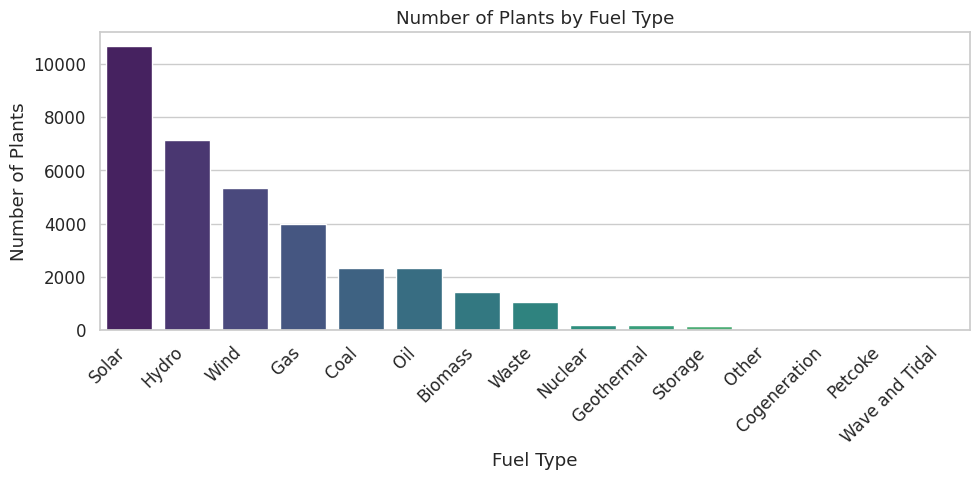

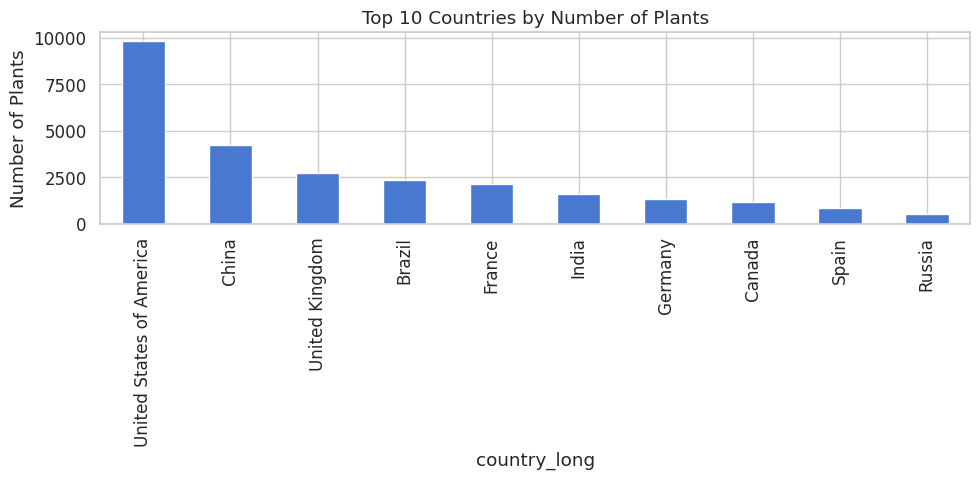

In [167]:
# ----------------------------
# EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------

print("\n📊 Descriptive statistics for numeric columns:")
print(df[numeric_cols].describe())

print("\n🌍 Top 10 countries by number of plants:")
print(df['country_long'].value_counts().head(10))

print("\n⚡ Distribution by fuel type:")
print(df['primary_fuel'].value_counts())


# Bar chart for ty;pes of plant
plt.figure(figsize=(10, 5))
sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="viridis")
plt.title("Number of Plants by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Number of Plants")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Bar chart for top 10 countries
plt.figure(figsize=(10, 5))
df['country_long'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Number of Plants")
plt.ylabel("Number of Plants")
plt.tight_layout()
plt.show()


In [168]:
# ----------------------------
# 5) STATISTICAL ANALYSIS
# ----------------------------

# Mean capacity by fuel type
mean_capacity_by_fuel = df.groupby('primary_fuel')['capacity_mw'].mean().sort_values(ascending=False)
print("\n📈 Mean Capacity (MW) by Fuel Type:")
print(mean_capacity_by_fuel)

# Prepare data for ANOVA test
groups = [group['capacity_mw'].dropna().values for _, group in df.groupby('primary_fuel')]

# Perform ANOVA test
f_stat, p_val = stats.f_oneway(*groups)
print(f"\n🔬 ANOVA Test Result: F-statistic = {f_stat:.3f}, p-value = {p_val:.5f}")
if p_val < 0.05:
    print("✅ There is a statistically significant difference in mean capacity between fuel types.")
else:
    print("ℹ️ No statistically significant difference detected between fuel types.")


📈 Mean Capacity (MW) by Fuel Type:
primary_fuel
Nuclear           2091.855179
Coal               843.579828
Gas                373.449375
Petcoke            202.048125
Hydro              147.171551
Oil                112.878754
Cogeneration        98.731707
Other               84.020000
Geothermal          67.130952
Wave and Tidal      55.220000
Wind                49.224126
Biomass             23.972938
Solar               17.657039
Waste               13.809657
Storage             12.683704
Name: capacity_mw, dtype: float64

🔬 ANOVA Test Result: F-statistic = 967.460, p-value = 0.00000
✅ There is a statistically significant difference in mean capacity between fuel types.


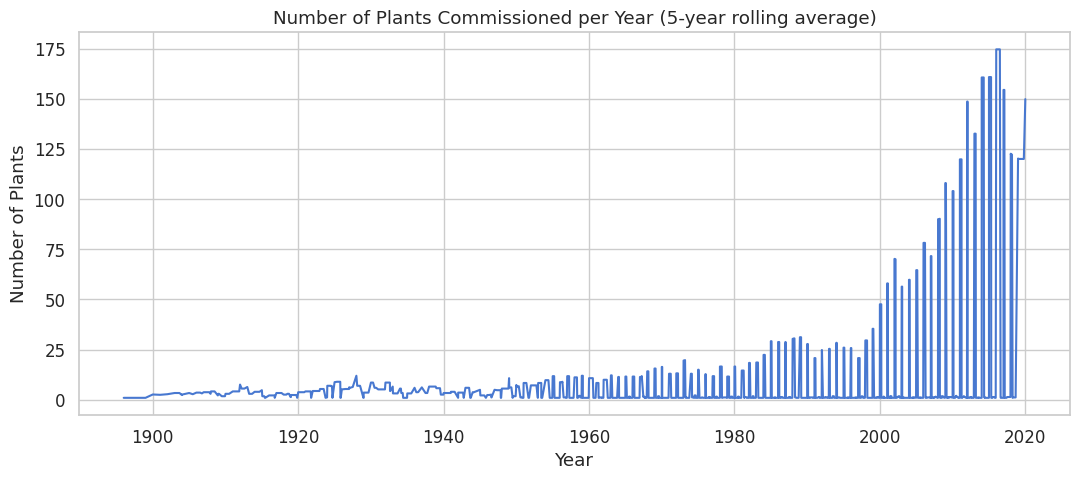

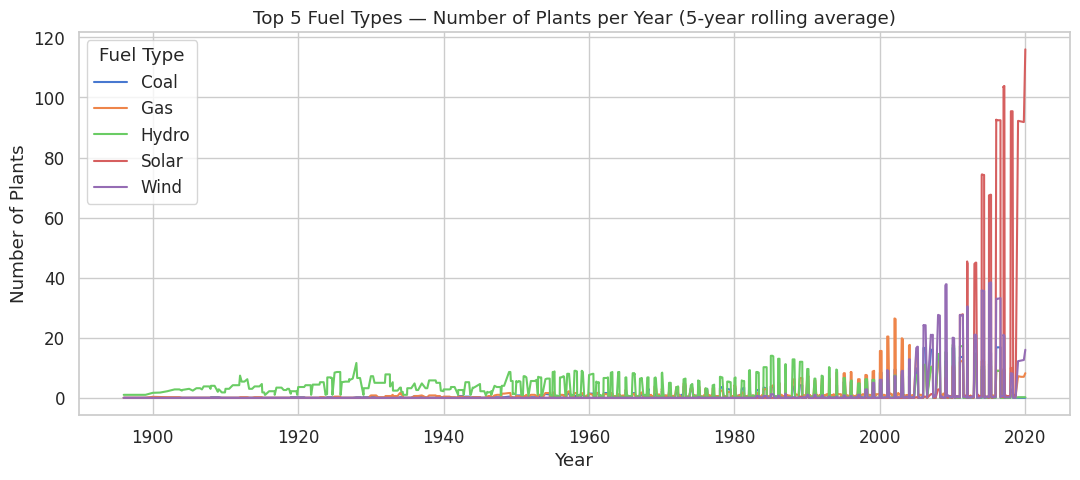

In [169]:
# ----------------------------
# 6) TIME SERIES ANALYSIS
# ----------------------------

# 1) Create a separate year column for time series analysis (keep NaN as missing)
df['year_ts'] = pd.to_numeric(df['commissioning_year'], errors='coerce')

# 2) Keep only realistic years (avoid 0 or future years)
current_year = pd.Timestamp.now().year
df['year_ts'] = df['year_ts'].where((df['year_ts'] >= 1880) & (df['year_ts'] <= current_year))

# 3) Count number of plants per year (excluding NaN)
plants_per_year = (
    df.dropna(subset=['year_ts'])
      .groupby('year_ts')
      .size()
      .sort_index()
)

# 4) Plot number of plants per year (5-year rolling average for smoother trend)
plants_per_year_5y = plants_per_year.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(11, 5))
plants_per_year_5y.plot()
plt.title("Number of Plants Commissioned per Year (5-year rolling average)")
plt.xlabel("Year")
plt.ylabel("Number of Plants")
plt.tight_layout()
plt.show()

# Focus on top 5 fuel types and show how many plants were built each year
top_fuels = df['primary_fuel'].value_counts().head(5).index
fuel_trend_top = (
    df[df['primary_fuel'].isin(top_fuels)]
    .dropna(subset=['year_ts'])
    .groupby(['year_ts', 'primary_fuel'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
    .rolling(window=5, min_periods=1).mean()
)

fuel_trend_top.plot(figsize=(11, 5))
plt.title("Top 5 Fuel Types — Number of Plants per Year (5-year rolling average)")
plt.xlabel("Year")
plt.ylabel("Number of Plants")
plt.legend(title="Fuel Type")
plt.tight_layout()
plt.show()

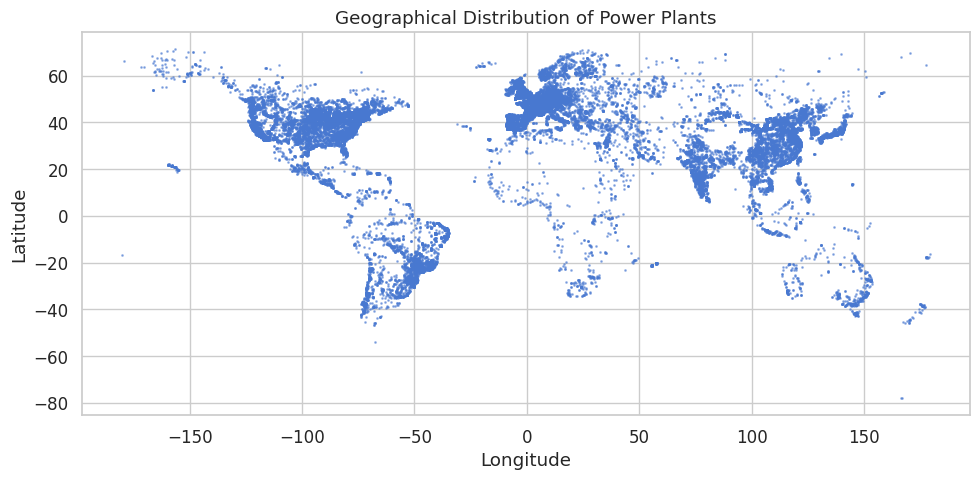

In [170]:
# Scatterplot of plants by location (rough geographic distribution)
plt.figure(figsize=(10, 5))
plt.scatter(df['longitude'], df['latitude'], s=1, alpha=0.5)
plt.title("Geographical Distribution of Power Plants")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [171]:
# ----------------------------
# MATRIX OPERATIONS & EIGENVALUES
# ----------------------------

# Correlation matrix of numeric features
corr_matrix = df[numeric_cols].corr()
print("\n🔗 Correlation Matrix:")
print(corr_matrix)

# Eigen decomposition (PCA-like analysis)
eig_vals, eig_vecs = np.linalg.eig(corr_matrix.fillna(0))
print("\n🔑 Eigenvalues (variance explained):")
print(eig_vals)
print("\n🔑 First Eigenvector (most influential direction):")
print(eig_vecs[:, 0])

# ----------------------------
# NUMPY INTEGRATION EXAMPLES
# ----------------------------

# Example: filtering using NumPy array
high_capacity = df[np.array(df['capacity_mw']) > 1000]
print(f"\n🔎 Number of plants with capacity > 1000 MW: {len(high_capacity)}")

# Example: custom NumPy histogram
data = df['capacity_mw'].dropna().values
counts, bins = np.histogram(data, bins=10)
print("\n📊 Custom NumPy Histogram (10 bins):")
print("Bin edges:", bins)
print("Counts:", counts)


🔗 Correlation Matrix:
                               capacity_mw  latitude  longitude  \
capacity_mw                       1.000000 -0.013218   0.151525   
latitude                         -0.013218  1.000000  -0.068354   
longitude                         0.151525 -0.068354   1.000000   
generation_gwh_2013               0.829836 -0.073264   0.050715   
generation_gwh_2014               0.830394 -0.097511   0.168033   
generation_gwh_2015               0.843868 -0.036456   0.195560   
generation_gwh_2016               0.844018 -0.026028   0.189760   
generation_gwh_2017               0.843724 -0.038374   0.219294   
generation_gwh_2018               0.832101 -0.106488   0.182328   
generation_gwh_2019               0.854440 -0.089446   0.033785   
estimated_generation_gwh_2013     0.965684 -0.049291   0.011608   
estimated_generation_gwh_2014     0.975443 -0.054559   0.018714   
estimated_generation_gwh_2015     0.973716 -0.050669   0.026318   
estimated_generation_gwh_2016     0.977